In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd

2 Logistic Regression

2.1

In [3]:
def data_generator(n,d,std):
  if d<5: 
    return 
  data = []
  for i in range(n):  
    temp = [0]          # first column remain for Y
    for i in range(d):  # X_i
      temp.append((-1)**(np.random.binomial(1,0.5))) 
    Check = 0
    for i in range(1,6):
      Check += 0.9**i * temp[i]
    Check += np.random.normal(loc=0,scale=std)
    if Check > 0:
      temp[0] = 1
    else:
      temp[0] = 0
    data.append(temp)
  return np.array(data)

In [4]:
def InformationGain(X,Y):
  n = len(Y)
  PosX = 0
  PosY = 0
  posXposY = 0
  negXposY = 0

  PosX = X[X==1]
  Prob_PosX = len(PosX)/n
  Prob_NegX = 1 - Prob_PosX

  PosY = Y[Y==1]
  Prob_PosY = len(PosY)/n
  Prob_NegY = 1 - Prob_PosY

  H_posY = 0
  H_negY = 0
  if Prob_PosY != 0:
    H_posY = - Prob_PosY * math.log2(Prob_PosY)
  if Prob_NegY != 0: 
    H_negY = - Prob_NegY * math.log2(Prob_NegY)
  H_Y = H_posY + H_negY

  for i in range(n):
    if Y[i] > 0: 
      if X[i] > 0: 
        posXposY += 1
      else:  
        negXposY += 1

  H_posYposX = 0
  if posXposY != 0:
    Prob_posYposX = posXposY/len(PosX)
    H_posYposX = - Prob_posYposX * math.log2(Prob_posYposX)
  H_negYposX = 0
  if len(PosX)-posXposY != 0:         # negative Y and positive X: len(PosX) is number of postive X
    Prob_negYposX = (len(PosX)-posXposY)/len(PosX)
    H_negYposX = - Prob_negYposX * math.log2(Prob_negYposX)
  H_posYnegX = 0
  if negXposY != 0:
    Prob_posYnegX = negXposY/(n-len(PosX))
    H_posYnegX = - Prob_posYnegX * math.log2(Prob_posYnegX)
  H_negYnegX = 0
  if ((n-len(PosX))-negXposY) != 0:      # negative Y and negative X: n-len(PosX) is number of negative X
    Prob_negYnegX = ((n-len(PosX))-negXposY)/(n-len(PosX))
    H_negYnegX = - Prob_negYnegX * math.log2(Prob_negYnegX)

  H_YposX = H_posYposX + H_negYposX
  H_YnegX = H_posYnegX + H_negYnegX
  H_YX = Prob_PosX * H_YposX + Prob_NegX * H_YnegX
  
  IG = H_Y - H_YX

  if(IG < 0):
    #print('error - IG<0: H_Y=',H_Y, ',H_YX=',H_YX)
    IG = 0

  return IG


def getBestIG(data,d): # d is number of variables
  IG = []
  IG.append(0)
  Y = data[:,0]
  for i in range(1,d+1):
    IG.append(InformationGain(data[:,i],Y))
  #if IG.index(max(IG)) == 0:
  #  return 1
  return IG.index(max(IG))


In [5]:
class Node():
  def __init__(self,d,y):
    self.d = d      # X_d
    self.y = y      # return value or threshold (not here)
    self.left = None
    self.right = None

In [ ]:
def getPosFraction(data):
  n = len(data)
  cnt = len(data[data[:,0] == 1])
  return cnt/n

def logistic_tree(data,d,size):
  if len(data) <= size:
    #print('stop since size')
    value = getPosFraction(data)
    temp = Node(None,value)    # Node.y is the return value for terminal nodes
    return temp

  variable = getBestIG(data,d)         # the variable with highest IG
  #print('variable=',variable)
  if variable == 0:  
    value = getPosFraction(data)           # all IG are zero
    return Node(None,value)
  if np.all(data[:,0] == data[:,0][0]):        # y are same 
    #print('stop since y the same')
    if data[:,0][0] == 1: 
      value = 1
    else:
      value = 0
    return Node(None,value)
  if np.all(data[:,variable] == data[:,variable][0]): # early termination
    #print('stop since early terminate')
    value = getPosFraction(data)
    return Node(None,value)

  Leftdata = data[data[:,variable] == -1]   # Left data are -1
  Rightdata = data[data[:,variable] == 1]   # Right data are +1

  root = Node(variable,0)
  root.left = logistic_tree(np.array(Leftdata),d,size)
  root.right = logistic_tree(np.array(Rightdata),d,size)
  return root

In [ ]:
def predict_D_Y(tree,data):
  ptr = tree
  while ptr.d != None:
    variable = ptr.d
    if data[variable] == -1:
      ptr = ptr.left
    else:
      ptr = ptr.right
  return ptr.y

def predict_log_error(test,tree):
  m = len(test)
  error = 0
  for i in range(m):
    w = predict_D_Y(tree,test[i])
    
    if w == 0:
      if test[i][0] == 1: 
        temp = 10
      else: 
        temp = 0
    elif w == 1 : 
      if (1-test[i][0]) == 1: 
        temp = 10
      else: 
        temp = 0
    else: 
      temp = - test[i][0] * np.log(w)-(1-test[i][0]) * np.log(1-w)
    error += temp
    
  return error / m

In [ ]:
train21 = data_generator(5000,15,0.05)
test21 = data_generator(500,15,0.05)

#find errors
Errors_train21 = []
Errors_test21 = []
Size = []
i = 5000
while i > 1 :
  DecisionTree = logistic_tree(train21,15,i)
  error_train = predict_log_error(train21,DecisionTree)
  error_test = predict_log_error(test21,DecisionTree)
  Errors_train21.append(error_train)
  Errors_test21.append(error_test)
  Size.append(i)
  #print('finish tree size =',i,' error = ',error_train, ',',error_test)
  i = math.floor(i/1.25)

print(Size)
print(Errors_train21)
print(Errors_test21)
print('optimal size is ',Size[Errors_train21.index(min(Errors_train21))])

[5000, 4000, 3200, 2560, 2048, 1638, 1310, 1048, 838, 670, 536, 428, 342, 273, 218, 174, 139, 111, 88, 70, 56, 44, 35, 28, 22, 17, 13, 10, 8, 6, 4, 3, 2]
[0.6930491773583193, 0.617246722346849, 0.617246722346849, 0.617246722346849, 0.5270420315301173, 0.5270420315301173, 0.5270420315301173, 0.4080290078334443, 0.4080290078334443, 0.4080290078334443, 0.24992294171139065, 0.24992294171139065, 0.24992294171139065, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.6931331828470028, 0.627101806359531, 0.627101806359531, 0.627101806359531, 0.5524195733042271, 0.5524195733042271, 0.5524195733042271, 0.44613868718627714, 0.44613868718627714, 0.44613868718627714, 0.2773071031943125, 0.2773071031943125, 0.2773071031943125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
optimal size is  273


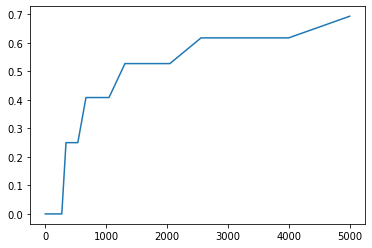

In [ ]:
plt.plot(Size,Errors_train21)

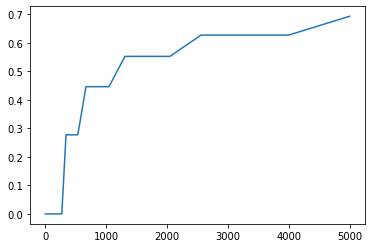

In [ ]:
plt.plot(Size,Errors_test21)

2.2

In [6]:
def sigmoid(w,x):         # sigmoid function
  power = - np.dot(w,x)
  F = 1/(1 + math.exp(power))
  return F

def log_error(w,X,Y):     # logistic error
  m = len(X)
  error = 0
  for i in range(m):
    F = sigmoid(w,X[i])
    temp = - Y[i]*np.log(F) - (1-Y[i])*np.log(1-F)
    error += temp
  return error / m

In [7]:
def findSGD(start,X,Y,alpha,iteration):
  k = 0
  current = start
  i = rd.choice(range(len(Y)))
  next = start-alpha*(sigmoid(current,X[i])-Y[i])*X[i]
  while k < iteration: 
    #print('current is ',current,', diff = ',np.linalg.norm(next - current))
    if isinstance(next[0], complex):
      break
    current = next
    i = rd.choice(range(len(Y)))
    next = current - alpha * (sigmoid(current,X[i])-Y[i]) * X[i] 
    k += 1
  return current,log_error(current,X,Y)

In [44]:
train22 = data_generator(5000,15,0.05)
test22 = data_generator(500,15,0.05)
variable = 15

X = [ row[1:] for row in train22 ]
X = np.hstack((np.ones((5000,1)),X))
Y = [ row[0] for row in train22 ]

X_test = [ row[1:] for row in test22 ]
X_test = np.hstack((np.ones((500,1)),X_test))
Y_test = [ row[0] for row in test22 ]

alpha = 1

w = []
Errors_train22 = []
Errors_test22 = []

w0 = np.zeros(variable+1)

for i in range(10000):
  #print('start = ',i)
  #w0 = np.random.rand(variable+1)
  wt,error_train = findSGD(w0,X,Y,alpha,i)
  error_test = log_error(wt,X_test,Y_test)
  w.append(wt)
  Errors_train22.append(error_train)
  Errors_test22.append(error_test)

#print(Errors_train22)
#print(Errors_test22)

C:\Users\trisc\AppData\Local\Temp/ipykernel_23200/3604022411.py:11: RuntimeWarning: divide by zero encountered in log
  temp = - Y[i]*np.log(F) - (1-Y[i])*np.log(1-F)
C:\Users\trisc\AppData\Local\Temp/ipykernel_23200/3604022411.py:11: RuntimeWarning: invalid value encountered in double_scalars
  temp = - Y[i]*np.log(F) - (1-Y[i])*np.log(1-F)


In [45]:
wb = w[Errors_train22.index(min(Errors_train22))]
print(wb)
index = Errors_train22.index(min(Errors_train22))
print(index,Errors_train22[index])

[ 2.01125548e-02  7.35246904e+00  7.32076051e+00  7.34265940e+00
  7.28181503e+00  7.31027226e+00 -6.16039037e-03  8.42541707e-03
 -1.05080868e-02 -1.80760143e-02 -2.08307175e-02  7.56712404e-03
  6.74167433e-03 -7.26904660e-04 -1.40351700e-02  6.33858040e-03]
7471 0.00041500878812144297


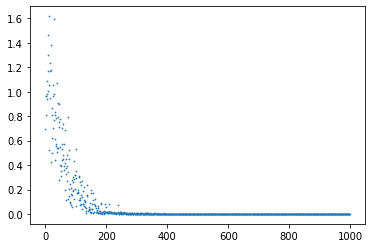

In [58]:
plt.scatter(range(1000),Errors_train22[:1000],s=0.5)

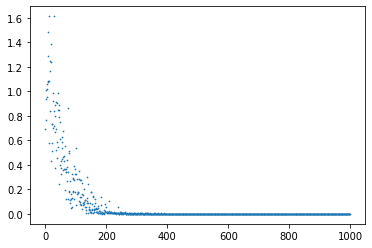

In [59]:
plt.scatter(range(1000),Errors_test22[:1000],s=0.5)

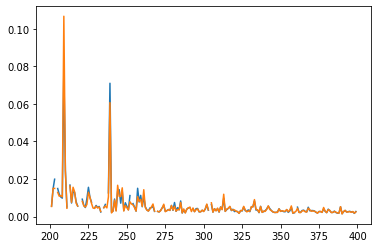

In [63]:
plt.plot(range(200,400),Errors_train22[200:400])
plt.plot(range(200,400),Errors_test22[200:400])

In [ ]:
Errors_train22 = np.array(Errors_train22)
Errors_test22 = np.array(Errors_test22)
plt.scatter(range(9000,10000),Errors_train22[9000:],s=2)
plt.scatter(range(9000,10000),Errors_test22[9000:],s=2)

2.2b - the following is smaller the range to look more specific. (could ignore this)

In [17]:
def findSGD2(start,X,Y,alpha,iteration):
  k = 0
  current = start
  w = []
  error = []
  i = rd.choice(range(len(Y)))
  next = start-alpha*(sigmoid(current,X[i])-Y[i])*X[i]
  while k < iteration: 
    #print('current is ',current,', diff = ',np.linalg.norm(next - current))
    w.append(current)
    error.append(log_error(current,X,Y))
    if isinstance(next[0], complex):
      break
    current = next
    i = rd.choice(range(len(Y)))
    next = current - alpha * (sigmoid(current,X[i])-Y[i]) * X[i] 
    k += 1
  index = error.index(min(error))
  return w[index],error[index]

In [ ]:
train22 = data_generator(5000,15,0.05)
test22 = data_generator(500,15,0.05)
variable = 15

X = [ row[1:] for row in train22 ]
X = np.hstack((np.ones((5000,1)),X))
Y = [ row[0] for row in train22 ]

X_test = [ row[1:] for row in test22 ]
X_test = np.hstack((np.ones((500,1)),X_test))
Y_test = [ row[0] for row in test22 ]

alpha = 1

w = []
Errors_train22b = []
Errors_test22b = []

w0 = np.zeros(variable+1)

for i in range(200,400,10):
  print('start = ',i)
  #w0 = np.random.rand(variable+1)
  wt,error_train = findSGD2(w0,X,Y,alpha,i)
  error_test = log_error(wt,X_test,Y_test)
  w.append(wt)
  Errors_train22b.append(error_train)
  Errors_test22b.append(error_test)

#print(Errors_train22)
#print(Errors_test22)

In [32]:
print(Errors_train22b)
wb = w[Errors_train22b.index(min(Errors_train22b))]
print(wb)
index = Errors_train22b.index(min(Errors_train22b))
print(range(200,400,10)[index],Errors_train22b[index])

[0.004610769937685861, 0.009055352173004636, 0.1702045823653262, 0.005291214798126428, 0.004683094042663099, 0.40347293968767944, 0.004067850078554915, 0.01752499856341361, 0.004486006604868478, 0.002768195875791532, 0.010229074482517364, 0.5712262921854774, 0.005552150638744596, 0.5494201403815013, 0.0030410788554839398, 0.0025838619762239305, 0.0038002255145115653, 0.0022342414101071927, 0.0015256503509134703, 0.0025443920669468885]
[-0.32681864  6.94615924  6.74887361  6.9213913   6.6986465   6.20184288
  0.51057005  0.2029844   0.22265506  0.50234544 -0.04635787  0.04115587
  0.07937897  0.33121716  0.38635596  0.04965901]
380 0.0015256503509134703


In [ ]:
plt.plot(range(200,400,10),Errors_train22b)

In [ ]:
plt.plot(range(200,400,10),Errors_test22b)